# Stock Price Forcasting Using Tensorflow - V2

In [112]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Micellaneous Functions

In [113]:
def drop_columns(hist):
    return hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

def set_size(num, df):
    return df.shape[0]-num

## Collecting the data

In [114]:
data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
n = len(df)
df

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94
...,...
2020-09-21,202.54
2020-09-22,207.42
2020-09-23,200.59


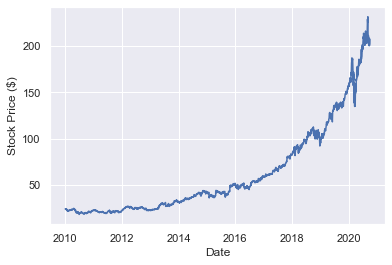

In [115]:
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()

## Pre-processing the data and creating a baseline with simple RNN

In [116]:
df['Date'] = pd.Categorical(df.index)
df['Date'] = df.Date.cat.codes
df.info

<bound method DataFrame.info of              Close  Date
Date                    
2010-01-04   24.17     0
2010-01-05   24.18     1
2010-01-06   24.03     2
2010-01-07   23.78     3
2010-01-08   23.94     4
...            ...   ...
2020-09-21  202.54  2697
2020-09-22  207.42  2698
2020-09-23  200.59  2699
2020-09-24  203.19  2700
2020-09-25  207.82  2701

[2702 rows x 2 columns]>

In [117]:
cols = ['Date', 'Close']
df = df.reindex(columns=cols)
df.head()

,Date,Close
Date,,
2010-01-04,0,24.17
2010-01-05,1,24.18
2010-01-06,2,24.03
2010-01-07,3,23.78
2010-01-08,4,23.94


In [131]:
value = df['Close']
time = np.arange(0, len(df), 1)
df_data = pd.DataFrame(value)
df_data.index = time

In [132]:
df_data

,Close
0,24.17
1,24.18
2,24.03
3,23.78
4,23.94
...,...
2697,202.54
2698,207.42
2699,200.59
2700,203.19


## Splitting the data

In [134]:
train_df = df_data[0:int(n*0.7)]
val_df = df_data[int(n*0.7):int(n*0.9)]
test_df = df_data[int(n*0.9):]

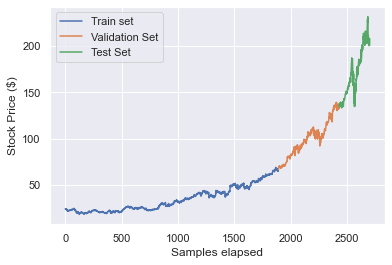

In [136]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.legend(['Train set', 'Validation Set', 'Test Set'])
plt.show()

In [137]:
len(train_df), len(val_df)

(1891, 540)

In [146]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

x_train, y_train = create_dataset(train_df, train_df['Close'], time_steps=10)
x_val, y_val = create_dataset(val_df, val_df['Close'], time_steps=10)

In [187]:
x_train, y_train

(array([[[24.17],
         [24.18],
         [24.03],
         ...,
         [23.7 ],
         [24.18],
         [24.1 ]],
 
        [[24.18],
         [24.03],
         [23.78],
         ...,
         [24.18],
         [24.1 ],
         [24.29]],
 
        [[24.03],
         [23.78],
         [23.94],
         ...,
         [24.1 ],
         [24.29],
         [23.89]],
 
        ...,
 
        [[66.49],
         [66.84],
         [66.83],
         ...,
         [65.14],
         [65.56],
         [64.84]],
 
        [[66.84],
         [66.83],
         [67.73],
         ...,
         [65.56],
         [64.84],
         [65.71]],
 
        [[66.83],
         [67.73],
         [67.08],
         ...,
         [64.84],
         [65.71],
         [65.22]]]),
 array([24.29, 23.89, 23.43, ..., 65.71, 65.22, 66.07]))

In [148]:
x_val.shape, y_val.shape

((530, 10, 1), (530,))

## Creating basic RNN model

In [188]:
import tensorflow as tf

def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2])),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.SimpleRNN(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    return model

model = get_compiled_model()
model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=1, shuffle=False)

Epoch 1/50
118/118 [==============================] - 1s 8ms/step - loss: 416.5908
Epoch 2/50
118/118 [==============================] - 1s 7ms/step - loss: 189.6234
Epoch 3/50
118/118 [==============================] - 1s 7ms/step - loss: 176.1741
Epoch 4/50
118/118 [==============================] - 1s 8ms/step - loss: 184.1547
Epoch 5/50
118/118 [==============================] - 1s 7ms/step - loss: 170.7245
Epoch 6/50
118/118 [==============================] - 1s 7ms/step - loss: 142.2180
Epoch 7/50
118/118 [==============================] - 1s 7ms/step - loss: 123.0127
Epoch 8/50
118/118 [==============================] - 1s 7ms/step - loss: 109.3828
Epoch 9/50
118/118 [==============================] - 1s 7ms/step - loss: 90.6664
Epoch 10/50
118/118 [==============================] - 1s 7ms/step - loss: 65.9633
Epoch 11/50
118/118 [==============================] - 1s 7ms/step - loss: 43.0703
Epoch 12/50
118/118 [==============================] - 1s 7ms/step - loss: 35.5708
Epoch

In [189]:
y_pred_val = model.predict(x_val)

In [191]:
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='test')
plt.show()

TypeError: 'History' object is not subscriptable

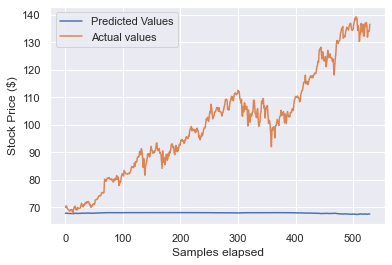

In [190]:
plt.plot(y_pred_val)
plt.plot(y_val)
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.legend(['Predicted Values', 'Actual values'])
# plt.savefig('simple_rnn_validation.jpg')